# Set-up

In [92]:
import os
import sys
import glob
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from PyComplexHeatmap import *

In [93]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [94]:
results_dir = "/cellar/users/aklie/projects/igvf/topic_grn_links/eval/results"
dataset_name = "meta_analysis"
in_date = "03Sep23"

# GRN metadata

In [400]:
# Read in all the network metadata
grn_metadata_df = pd.read_csv(os.path.join(results_dir, dataset_name, in_date, "cleaned_grn_metadata.tsv"), sep="\t", index_col=0)

In [401]:
grn_metadata_df = grn_metadata_df[(grn_metadata_df["genotype"] != "both") & (grn_metadata_df["method"] == "celloracle") & (grn_metadata_df["normalization"] == "pf_log1p_pf") & (grn_metadata_df["dataset"] == "igvf_b01_LeftCortex")]
len(grn_metadata_df)

2

# TF metadata

In [402]:
# Read in the metadata
tf_metadata_df = pd.read_csv(os.path.join(results_dir, dataset_name, in_date, "tf_metadata_topics_baselines.tsv"), sep="\t", index_col=0)
len(tf_metadata_df)

709

In [403]:
# Sort by presence in literature
tf_metadata_df = tf_metadata_df.sort_values(by="in_literature", ascending=False)
tf_metadata_df.head()

,in_scenic,in_aracne,in_celloracle,in_literature,number_grns,in_topics,in_igvf_b01_LeftCortex,in_Bridge_Satpathy,in_both,in_neither
Mef2a,True,True,True,True,93,True,True,True,True,False
Runx1,True,False,True,True,76,True,True,True,True,False
Mef2c,True,True,True,True,87,True,True,True,True,False
Stat3,True,True,True,True,43,True,True,True,True,False
Sall1,True,True,False,True,29,True,True,True,True,False


# TF network scores

In [404]:
# Read in the network scores
tf_scores_df = pd.read_csv(os.path.join(results_dir, dataset_name, in_date, "tf_only_network_scores.tsv"), sep="\t").rename(columns={"Unnamed: 0": "tf_name"})
tf_scores_df.head()

,tf_name,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,grn_name
0,Runx1t1,2,0.004866,0,0.000000,2,0.004866,0.0,0.005795,Bridge_Satpathy_aracne_balanced_genotype_micro...
1,Runx1t1,50,0.142045,2,0.005682,48,0.136364,81.0,0.226653,Bridge_Satpathy_aracne_balanced_genotype_micro...
2,Runx1t1,37,0.099196,1,0.002681,36,0.096515,24.0,0.183886,Bridge_Satpathy_aracne_balanced_genotype_micro...
3,Runx1t1,1,0.001031,1,0.001031,0,0.000000,0.0,0.014566,Bridge_Satpathy_celloracle_balanced_genotype_m...
4,Runx1t1,1,0.001211,1,0.001211,0,0.000000,0.0,0.015317,Bridge_Satpathy_celloracle_balanced_genotype_m...


In [405]:
# Check to make sure all the tfs in the scores are in the metadata
(~tf_scores_df.tf_name.isin(tf_metadata_df.index)).sum()

0

In [406]:
# Subset to scores that are in the metadata
tf_scores_df = tf_scores_df[tf_scores_df.grn_name.isin(grn_metadata_df.index)]
tf_scores_df["grn_name"].unique()

array(['igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf',
       'igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf'],
      dtype=object)

In [407]:
# Normalize the scores to between 0 and 1
cols_to_normalize = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']
tf_scores_df[cols_to_normalize] = tf_scores_df[cols_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
tf_scores_df.head()

,tf_name,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,grn_name
152,Zfx,0.107692,0.103309,0.0,0.0,0.129032,0.123857,0.0,0.042900,igvf_b01_LeftCortex_celloracle_balanced_genoty...
153,Zfx,0.123077,0.123618,0.0,0.0,0.145161,0.145161,0.0,0.048213,igvf_b01_LeftCortex_celloracle_balanced_genoty...
240,Klf7,0.261538,0.250894,0.0,0.0,0.290323,0.278679,0.0,0.112184,igvf_b01_LeftCortex_celloracle_balanced_genoty...
241,Klf7,0.246154,0.246619,0.0,0.0,0.274194,0.274194,0.0,0.194964,igvf_b01_LeftCortex_celloracle_balanced_genoty...
343,Nr1d2,0.061538,0.059034,0.0,0.0,0.080645,0.077411,0.0,0.030733,igvf_b01_LeftCortex_celloracle_balanced_genoty...


# Dot plot across metrics

In [408]:
grn_1 = "igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf"
grn_2 = "igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf"

In [409]:
# Keep only tf_names that appear in separate rows for each of grn_names
tf_scores_df = tf_scores_df.groupby("tf_name").filter(lambda x: len(x) == 2)
tf_scores_df.head()

,tf_name,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,grn_name
152,Zfx,0.107692,0.103309,0.0,0.0,0.129032,0.123857,0.0,0.042900,igvf_b01_LeftCortex_celloracle_balanced_genoty...
153,Zfx,0.123077,0.123618,0.0,0.0,0.145161,0.145161,0.0,0.048213,igvf_b01_LeftCortex_celloracle_balanced_genoty...
240,Klf7,0.261538,0.250894,0.0,0.0,0.290323,0.278679,0.0,0.112184,igvf_b01_LeftCortex_celloracle_balanced_genoty...
241,Klf7,0.246154,0.246619,0.0,0.0,0.274194,0.274194,0.0,0.194964,igvf_b01_LeftCortex_celloracle_balanced_genoty...
343,Nr1d2,0.061538,0.059034,0.0,0.0,0.080645,0.077411,0.0,0.030733,igvf_b01_LeftCortex_celloracle_balanced_genoty...


In [410]:
# Get the top tf_name based difference[metric] difference between two remaining grn_name groups
tfs_to_plot = set()
for metric in cols_to_normalize:

    # Get the difference between the two grn_names for each tf_name
    ec_diff = tf_scores_df.groupby("tf_name").apply(lambda x: x[x.grn_name == grn_1][metric].values[0] - x[x.grn_name == grn_2][metric].values[0])

    # Make a dataframe from the series
    ec_diff_df = pd.DataFrame(ec_diff).rename(columns={0: "ec_diff"})

    # Add in the sign of the difference
    ec_diff_df["sign"] = np.sign(ec_diff_df["ec_diff"])

    # Replace sign with up or down
    ec_diff_df["sign"] = ec_diff_df["sign"].replace({1: "CASTJ", -1: "B6J"})

    # Add in absolute value of the difference
    ec_diff_df["abs_ec_diff"] = np.abs(ec_diff_df["ec_diff"])

    # Sort by absolute value of the difference
    ec_diff_df = ec_diff_df.sort_values(by="abs_ec_diff", ascending=False)

    # Add the top 25
    tfs_to_plot.update(set(ec_diff_df.head(10).index))

In [411]:
metric = "eigenvector_centrality"

# Get the difference between the two grn_names for each tf_name
ec_diff = tf_scores_df.groupby("tf_name").apply(lambda x: x[x.grn_name == grn_1][metric].values[0] - x[x.grn_name == grn_2][metric].values[0])

# Make a dataframe from the series
ec_diff_df = pd.DataFrame(ec_diff).rename(columns={0: "ec_diff"})

# Add in the sign of the difference
ec_diff_df["sign"] = np.sign(ec_diff_df["ec_diff"])

# Replace sign with up or down
ec_diff_df["sign"] = ec_diff_df["sign"].replace({1: "CASTJ", -1: "B6J"})

# Add in absolute value of the difference
ec_diff_df["abs_ec_diff"] = np.abs(ec_diff_df["ec_diff"])

# Sort by absolute value of the difference
ec_diff_df = ec_diff_df.sort_values(by="abs_ec_diff", ascending=False)

In [412]:
len(tfs_to_plot)

29

In [413]:
tf_metadata_df = ec_diff_df.loc[tfs_to_plot].merge(tf_metadata_df, left_index=True, right_index=True)

/tmp/ipykernel_2728005/113715477.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  tf_metadata_df = ec_diff_df.loc[tfs_to_plot].merge(tf_metadata_df, left_index=True, right_index=True)


In [414]:
data = tf_scores_df[tf_scores_df.tf_name.isin(tf_metadata_df.index)]

In [415]:
# Need to create long dataframe with ["betweenness_centrality", "eigenvector_centrality" as values
data = data.melt(id_vars=["tf_name", "grn_name"], value_vars=cols_to_normalize, var_name="metric", value_name="score")
data["ID"] = data["grn_name"] + "-" + data["metric"]
data = data.merge(grn_metadata_df.reset_index()[["grn_name", "dataset", "genotype"]], on="grn_name")
data.head()

,tf_name,grn_name,metric,score,ID,dataset,genotype
0,Rora,igvf_b01_LeftCortex_celloracle_balanced_genoty...,degree_all,0.707692,igvf_b01_LeftCortex_celloracle_balanced_genoty...,igvf_b01_LeftCortex,B6J
1,Bach2,igvf_b01_LeftCortex_celloracle_balanced_genoty...,degree_all,0.138462,igvf_b01_LeftCortex_celloracle_balanced_genoty...,igvf_b01_LeftCortex,B6J
2,Smc3,igvf_b01_LeftCortex_celloracle_balanced_genoty...,degree_all,0.400000,igvf_b01_LeftCortex_celloracle_balanced_genoty...,igvf_b01_LeftCortex,B6J
3,Rbpj,igvf_b01_LeftCortex_celloracle_balanced_genoty...,degree_all,0.507692,igvf_b01_LeftCortex_celloracle_balanced_genoty...,igvf_b01_LeftCortex,B6J
4,Nfkb1,igvf_b01_LeftCortex_celloracle_balanced_genoty...,degree_all,0.200000,igvf_b01_LeftCortex_celloracle_balanced_genoty...,igvf_b01_LeftCortex,B6J


In [416]:
# Create row annotation dataframe
df_cols = data.set_index("ID")[["metric", "genotype"]]

# Deduplicate
df_cols = df_cols[~df_cols.index.duplicated(keep='first')]

# Order by metric
df_cols = df_cols.sort_values(by="metric", ascending=False)

# Head
df_cols.head()

,metric,genotype
ID,,
igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf-eigenvector_centrality,eigenvector_centrality,B6J
igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf-eigenvector_centrality,eigenvector_centrality,CASTJ
igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf-degree_out,degree_out,B6J
igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf-degree_out,degree_out,CASTJ
igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf-degree_in,degree_in,B6J


In [417]:
# Create col annotation dataframe
df_rows = tf_metadata_df[["in_literature", "sign"]].replace({True: "Yes", False: "No"})
df_rows

,in_literature,sign
Nfatc3,No,B6J
Mef2a,Yes,B6J
Rreb1,No,B6J
Elf1,No,B6J
Esrrg,No,B6J
Ikzf1,No,B6J
Zbtb20,No,CASTJ
Pbx1,No,B6J
Zeb1,No,CASTJ
Mef2c,Yes,B6J


In [418]:
# Column annotations
col_ha = HeatmapAnnotation(
    Metric=anno_simple(df_cols.metric, legend=False, cmap="Set1", add_text=True),
    Genotype=anno_simple(df_cols.genotype, legend=False, cmap="Dark2", add_text=True),
    verbose=0,label_side='left',label_kws={'horizontalalignment':'right'},
)

In [419]:
# Row annotations
row_ha = HeatmapAnnotation(
    Sign=anno_simple(df_rows.sign, legend=False, cmap="Dark2"),
    label=anno_label(df_rows.sign, merge=True,rotation=0, cmap="Dark2"),
    axis=0,verbose=0,label_kws={'rotation':45,'horizontalalignment':'left'}
)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..


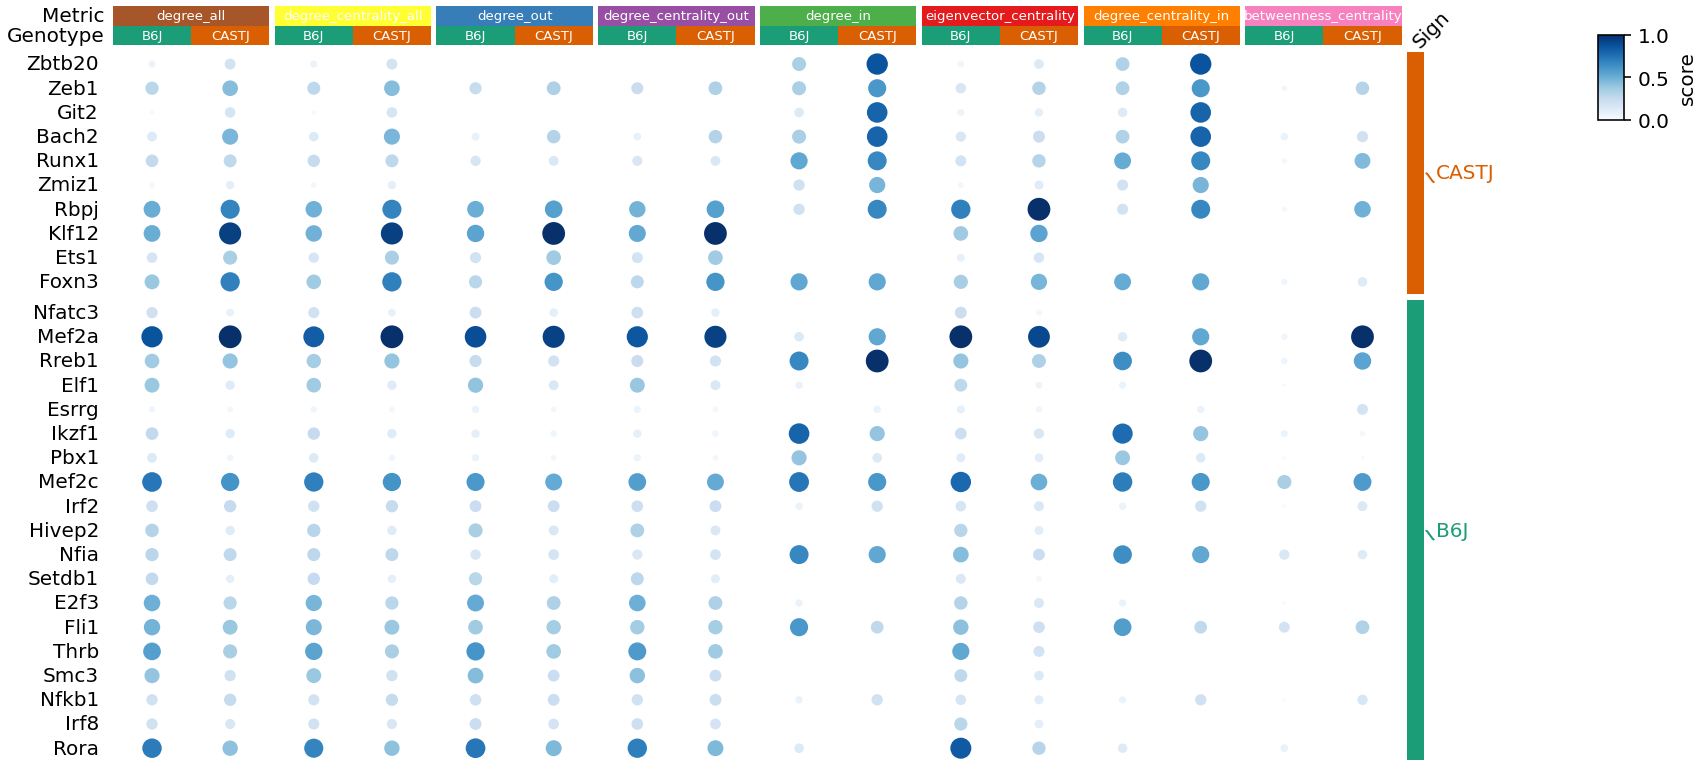

In [421]:
# Plot the heatmap
plt.figure(figsize=(12, 6))
cm = DotClustermapPlotter(
    data=data,
    x="ID",
    y="tf_name",
    value="score",
    c='score',
    cmap='Blues',
    show_rownames=True,
    row_cluster=False,
    col_cluster=False,
    top_annotation=col_ha,
    right_annotation=row_ha,
    col_split=df_cols.metric,
    col_split_gap=1,
    row_split=df_rows.sign,
    row_split_gap=1
)
plt.show()

# Select GRNs to compare across genotypes

In [74]:
method = "celloracle"
normalization = "pf_log1p_pf"
#selected_metadata = grn_metadata_df
selected_metadata = grn_metadata_df.query("method == @method and normalization == @normalization")

In [75]:
links_dict = {}
for i, (grn_name, row) in tqdm(enumerate(selected_metadata.iterrows()), total=len(selected_metadata)):
    links_df = pd.read_csv(row["filtered_links_path"], sep="\t")
    links_df["coef"] = links_df["weight_signed"]
    links_df["coef_abs"] = links_df["weight_unsigned"]
    links_dict[grn_name] = links_df

  0%|          | 0/6 [00:00<?, ?it/s]

In [76]:
# Make a celloracle links object
links = co.Links(name="celloracle_pf_log1p_pf_cross_genotype_microglia_comparison", links_dict=links_dict)

In [77]:
# Filter to top 2000 links
links.filter_links(weight="weight_unsigned", p=None, threshold_number=2000)

In [78]:
# Calculate network scores.
links.get_network_score()

In [79]:
# Save gene scores for each gene in the network
gene_scores = links.merged_score

In [81]:
selected_metadata

,dataset,method,cells,genes,normalization,genotype,scale_free_topology_score,mean_connectivity,median_connectivity,max_connectivity,number_tfs,filtered_links_path,degree_centrality_out_path,eigenvector_centrality_path,betweenness_centrality_path,ulm_path,viper_path,aucell_path
grn_name,,,,,,,,,,,,,,,,,,
igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf,igvf_b01_LeftCortex,celloracle,balanced_genotype_microglia,0.05,pf_log1p_pf,B6J,0.889136,5.340454,3.0,57.0,182,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...
igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf,igvf_b01_LeftCortex,celloracle,balanced_genotype_microglia,0.05,pf_log1p_pf,CASTJ,0.878897,5.563282,3.0,66.0,177,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...
igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_both_0.05_pf_log1p_pf,igvf_b01_LeftCortex,celloracle,balanced_genotype_microglia,0.05,pf_log1p_pf,both,0.835246,5.471956,3.0,193.0,172,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...
Bridge_Satpathy_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf,Bridge_Satpathy,celloracle,balanced_genotype_microglia,0.05,pf_log1p_pf,B6J,0.807120,5.427408,3.0,197.0,189,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...
Bridge_Satpathy_celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf,Bridge_Satpathy,celloracle,balanced_genotype_microglia,0.05,pf_log1p_pf,CASTJ,0.844570,5.738881,2.0,185.0,188,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...
Bridge_Satpathy_celloracle_balanced_genotype_microglia_both_0.05_pf_log1p_pf,Bridge_Satpathy,celloracle,balanced_genotype_microglia,0.05,pf_log1p_pf,both,0.851157,6.379585,2.0,237.0,150,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...


In [65]:
# assign a color to each key in links_dict based on a seaborn palette
palette = sns.color_palette('Paired', len(links_dict))
links.palette = pd.DataFrame({'key': links_dict.keys(), 'palette': palette}).set_index('key')

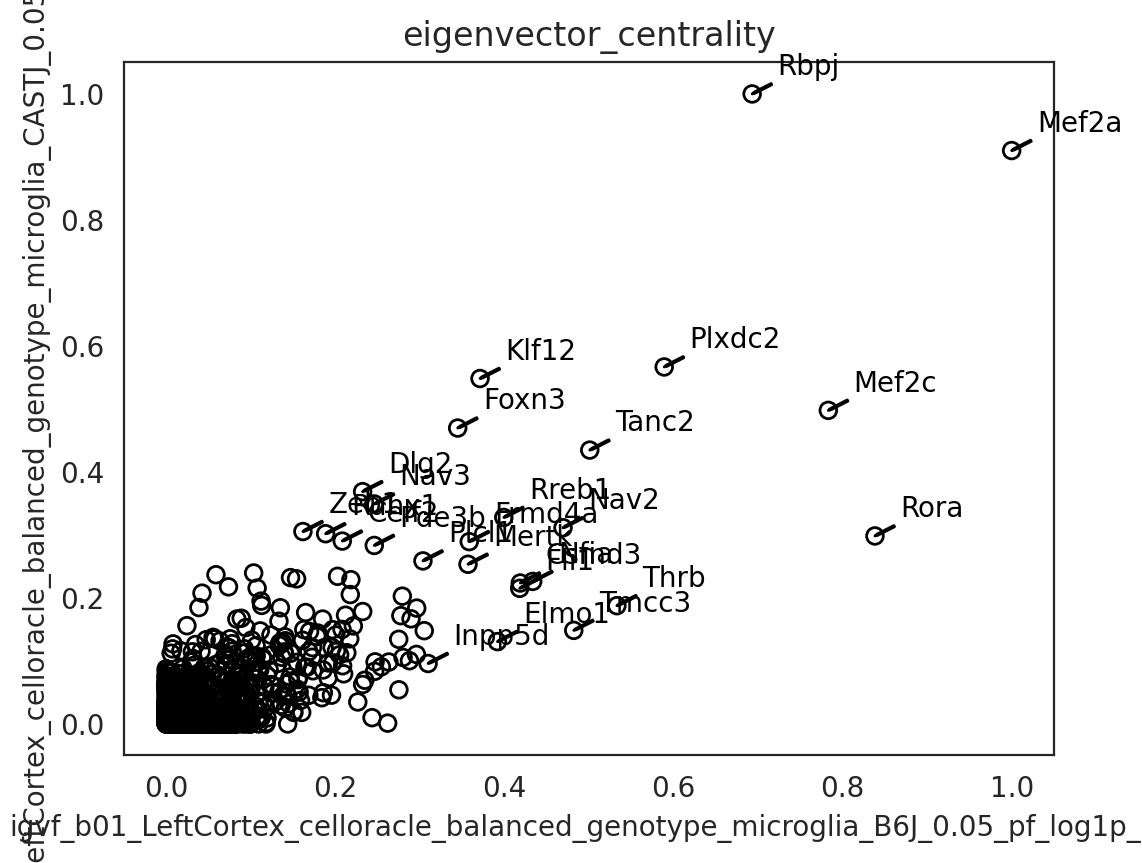

In [70]:
# Cross genotype, same algorithm
links.plot_score_comparison_2D(
    value="eigenvector_centrality",
    cluster1="igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf", 
    cluster2="igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf",
    percentile=98
)

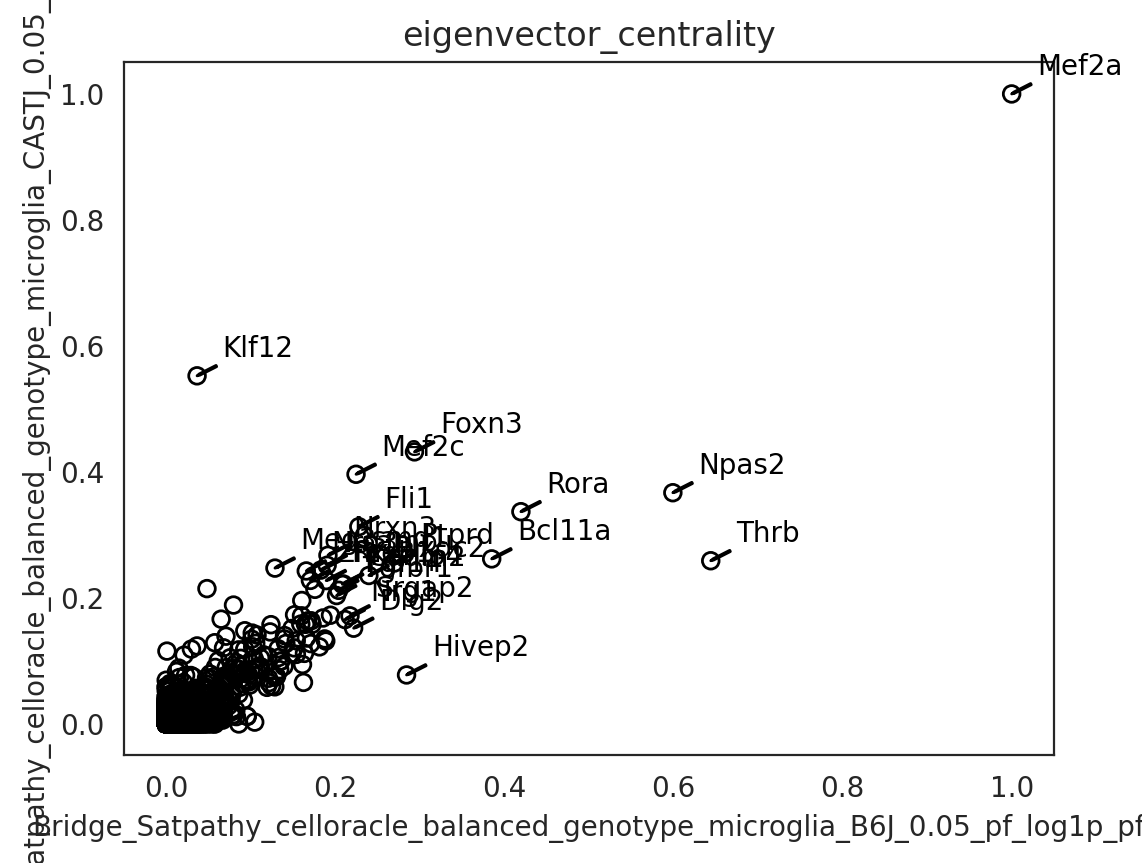

In [72]:
# Cross genotype, same algorithm
links.plot_score_comparison_2D(
    value="eigenvector_centrality",
    cluster1="Bridge_Satpathy_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf", 
    cluster2="Bridge_Satpathy_celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf",
    percentile=98
)

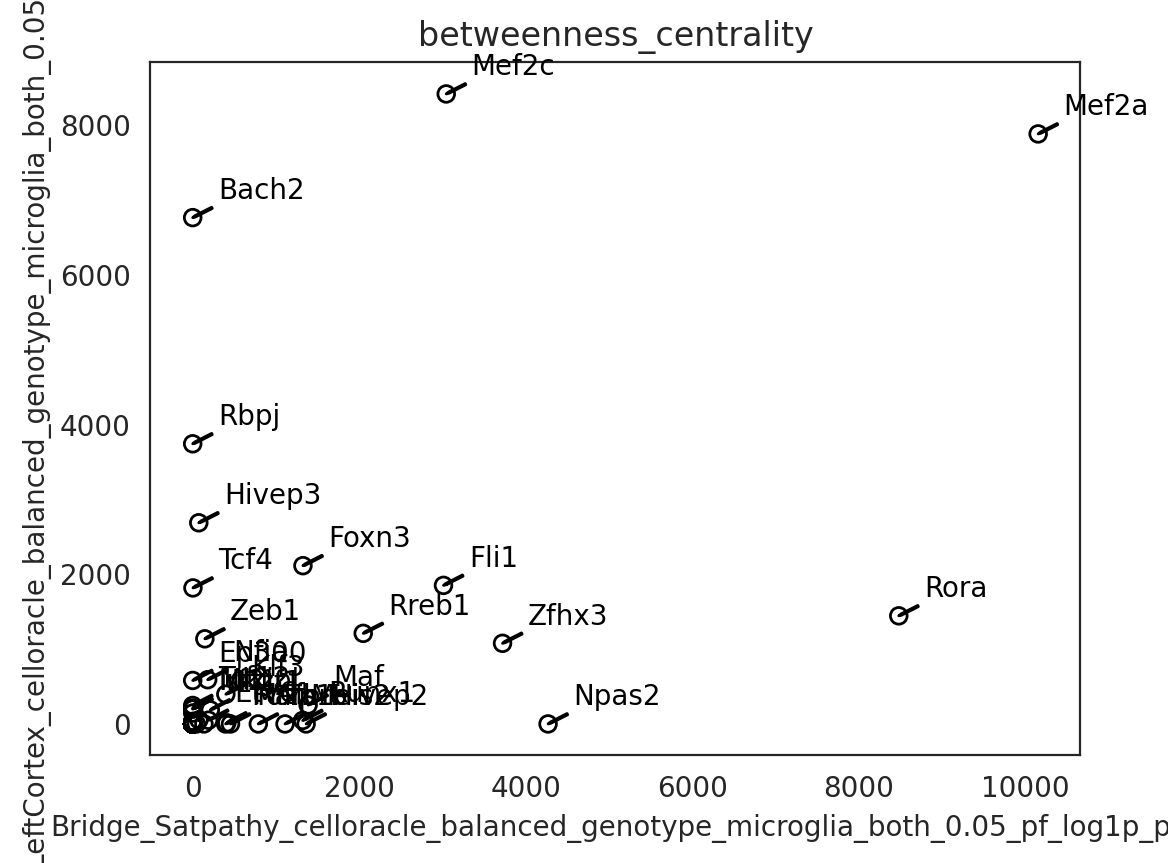

In [50]:
# Cross genotype, same algorithm
links.plot_score_comparison_2D(
    value="betweenness_centrality",
    cluster1="Bridge_Satpathy_celloracle_balanced_genotype_microglia_both_0.05_pf_log1p_pf", 
    cluster2="igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_both_0.05_pf_log1p_pf",
    percentile=98
)

In [48]:
# Grab a list of the tfs in the literature
lit_tfs = tf_metadata_df[tf_metadata_df["in_literature"]].index

Mef2a


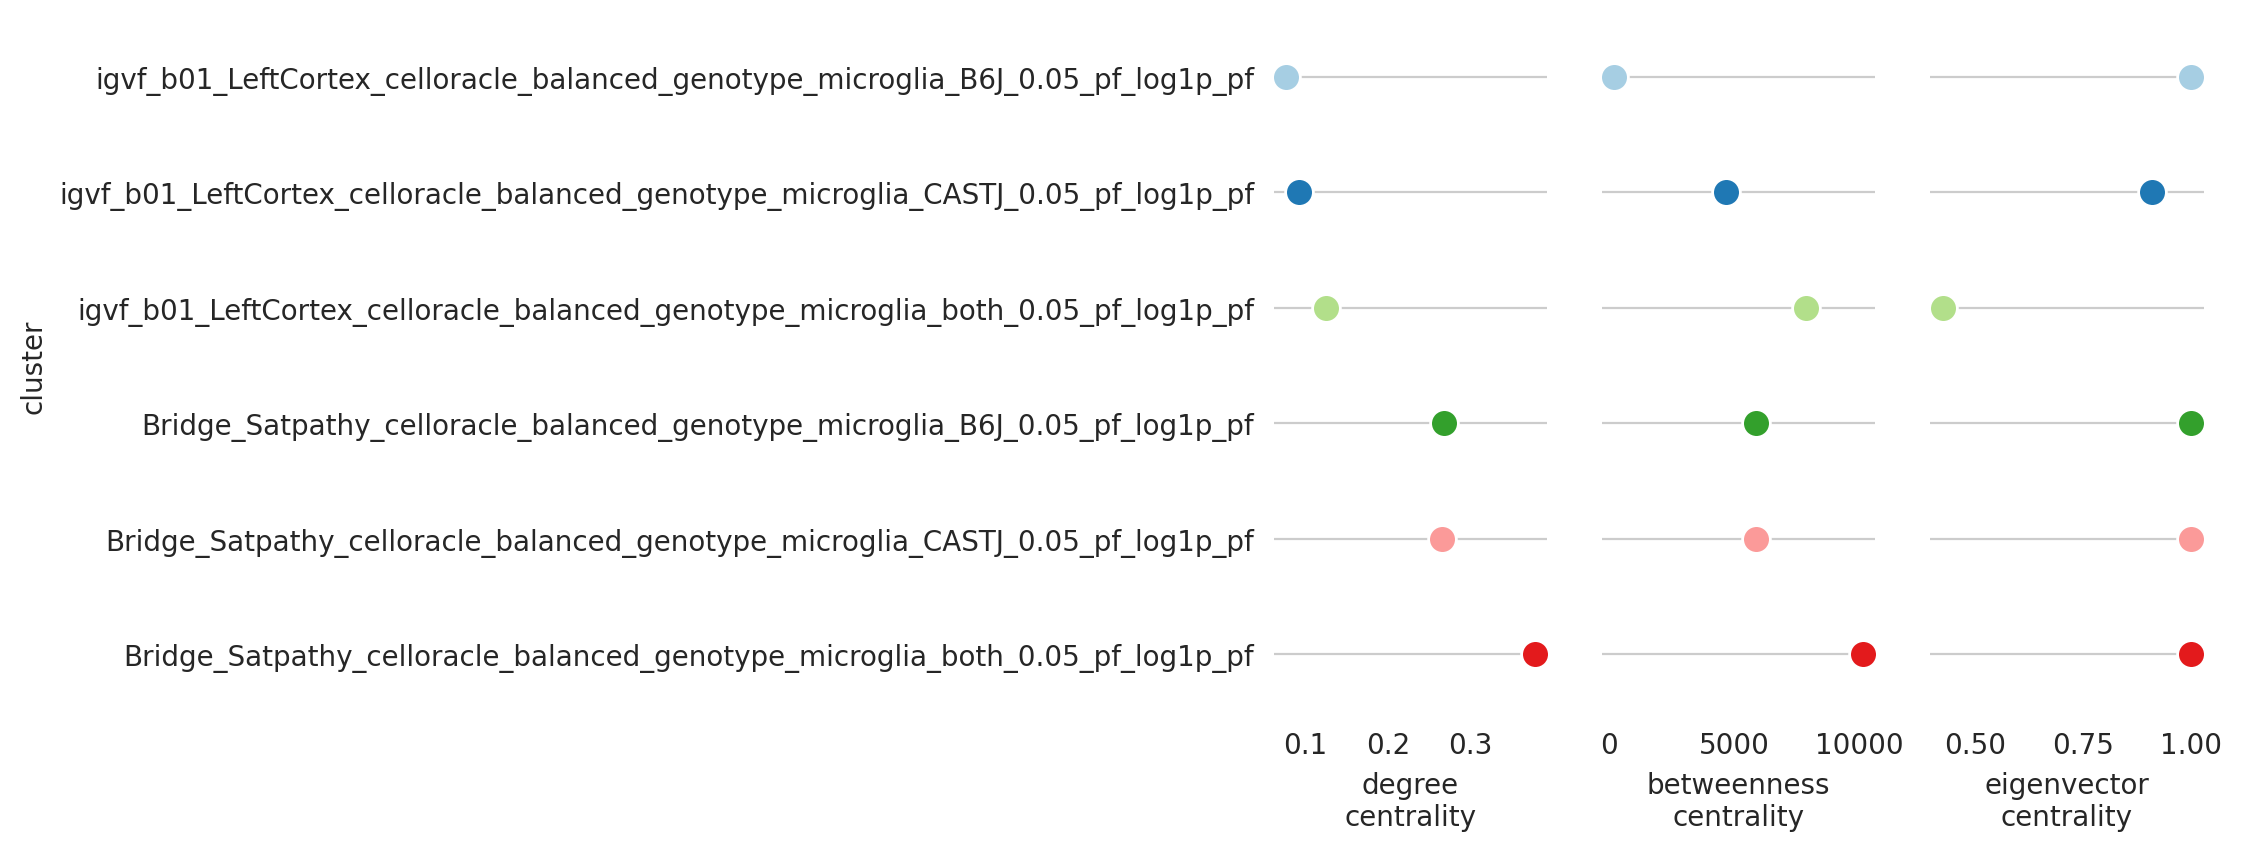

Runx1


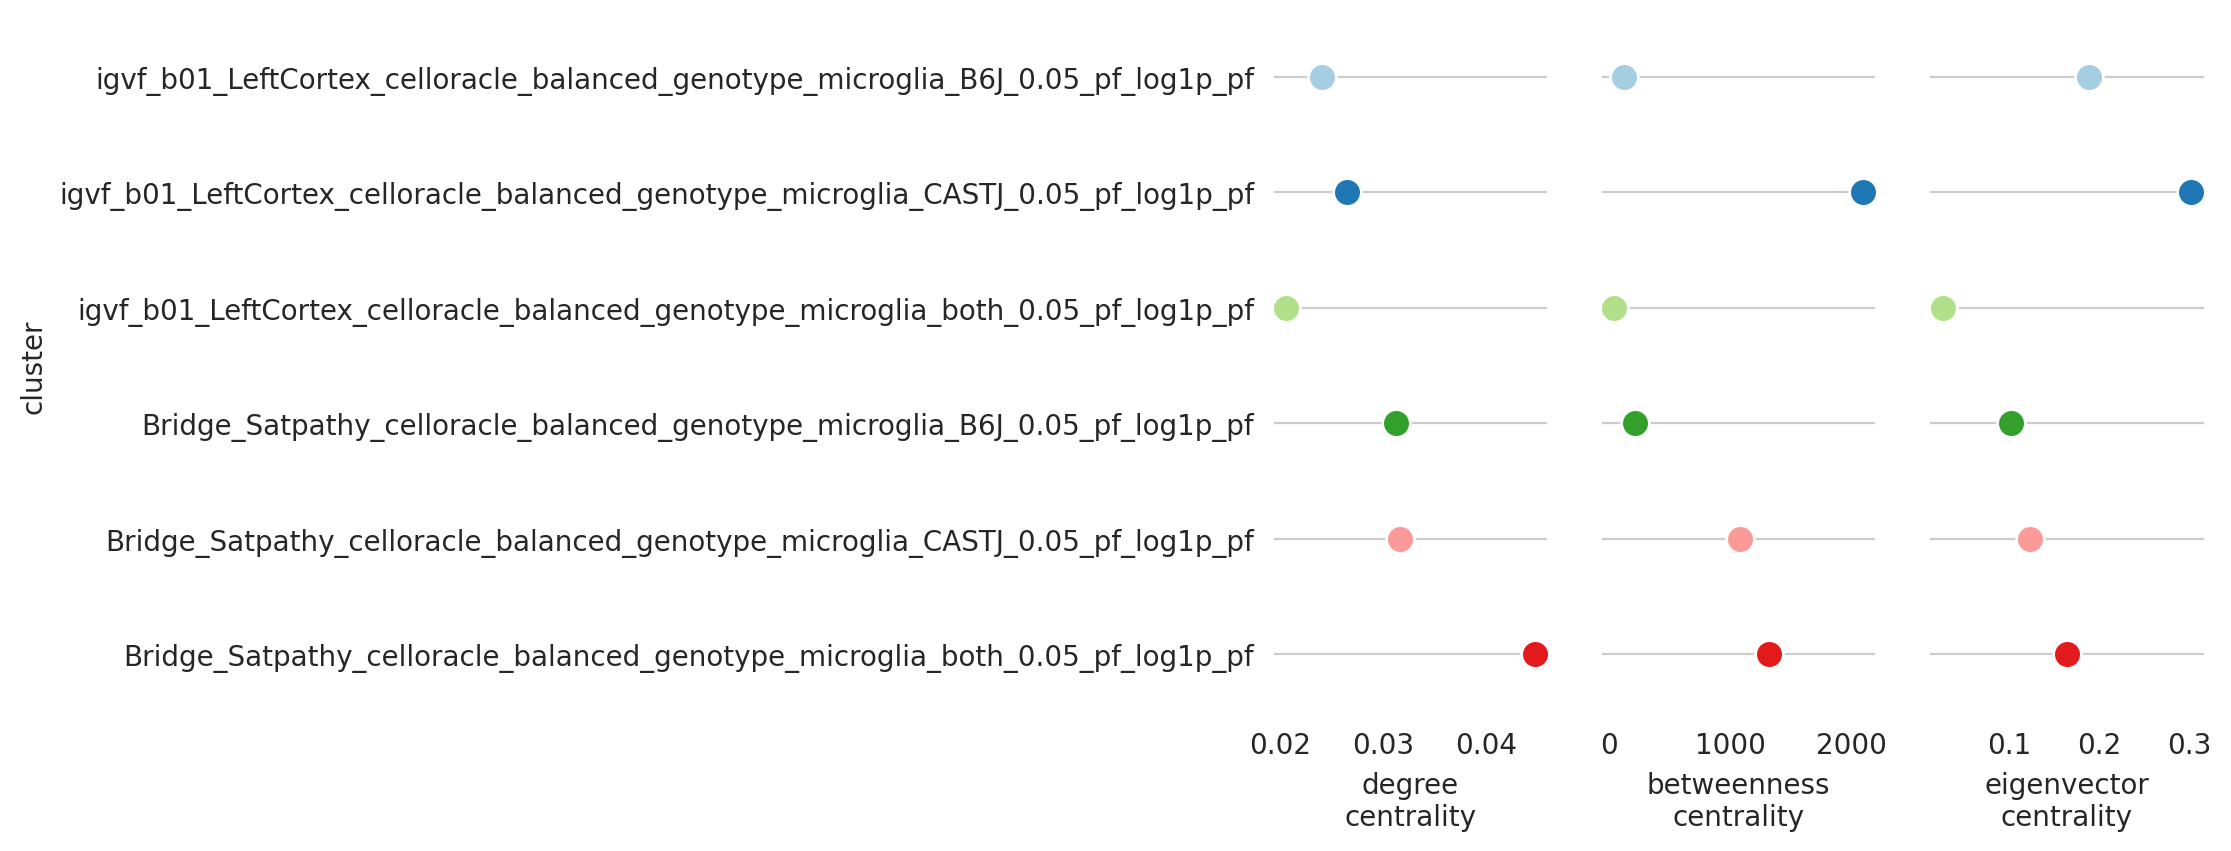

Mef2c


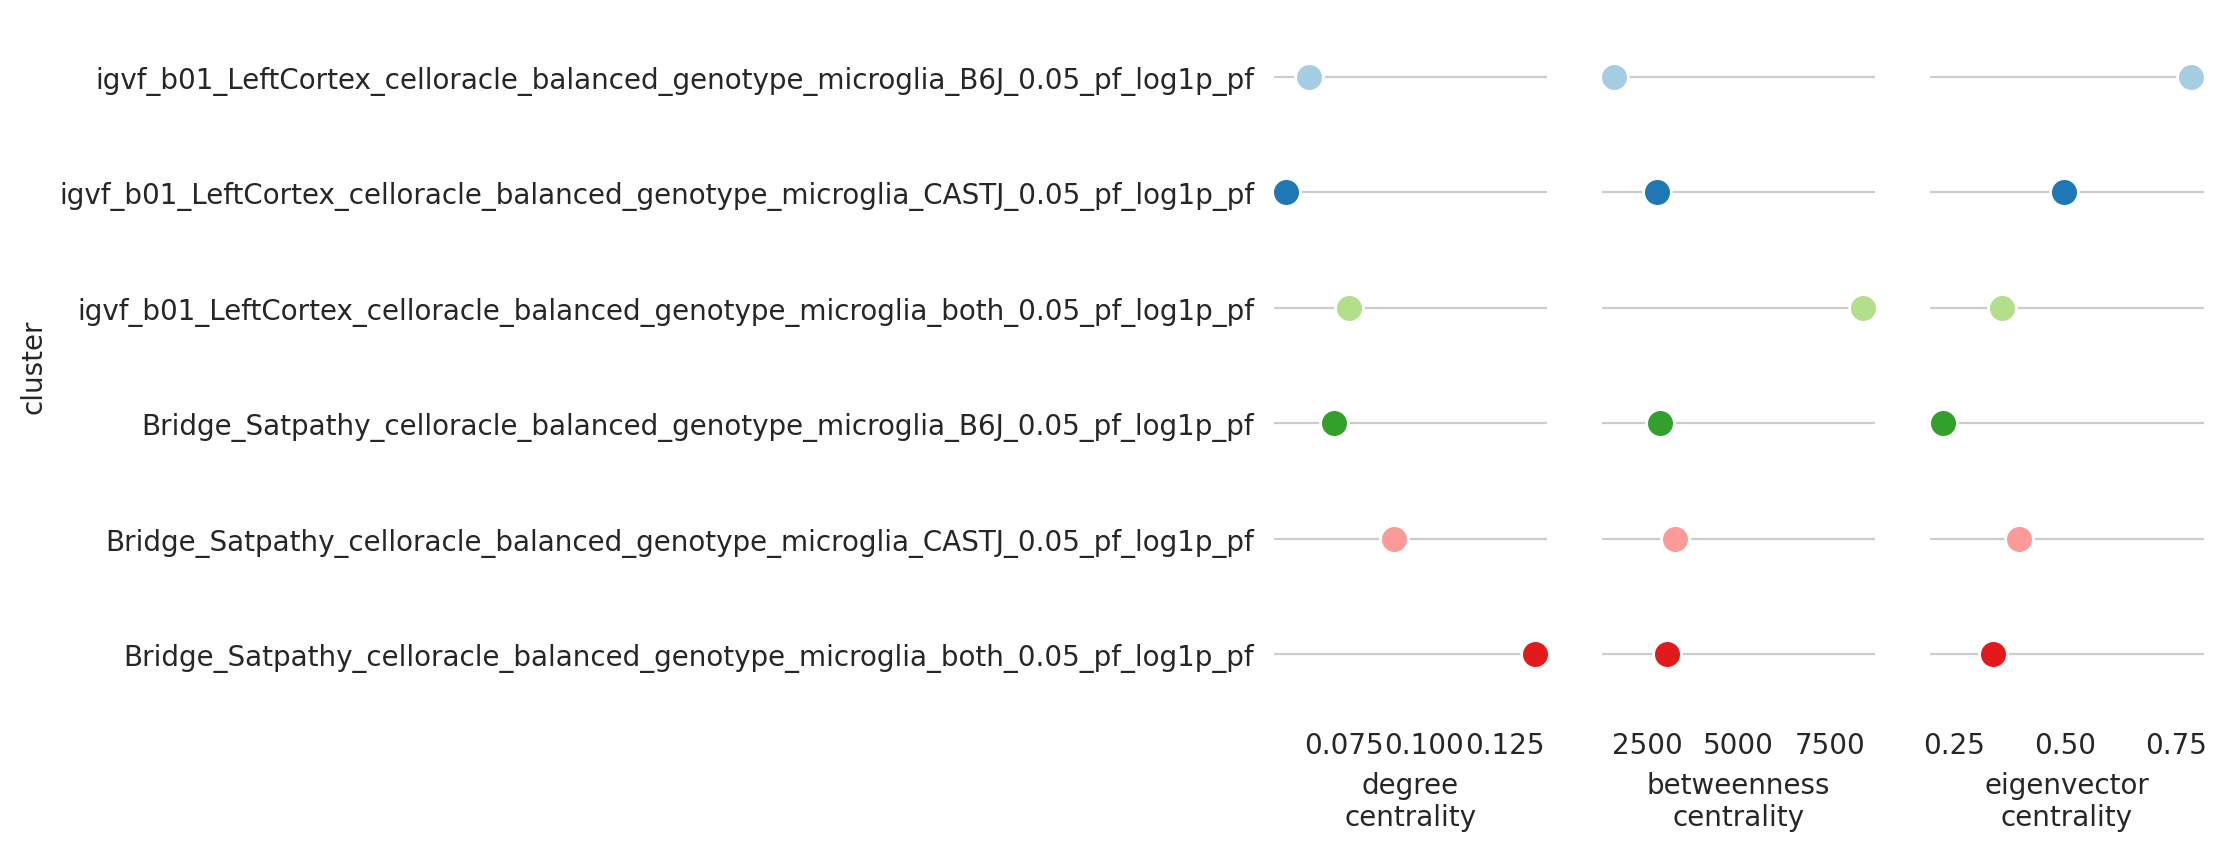

Stat3


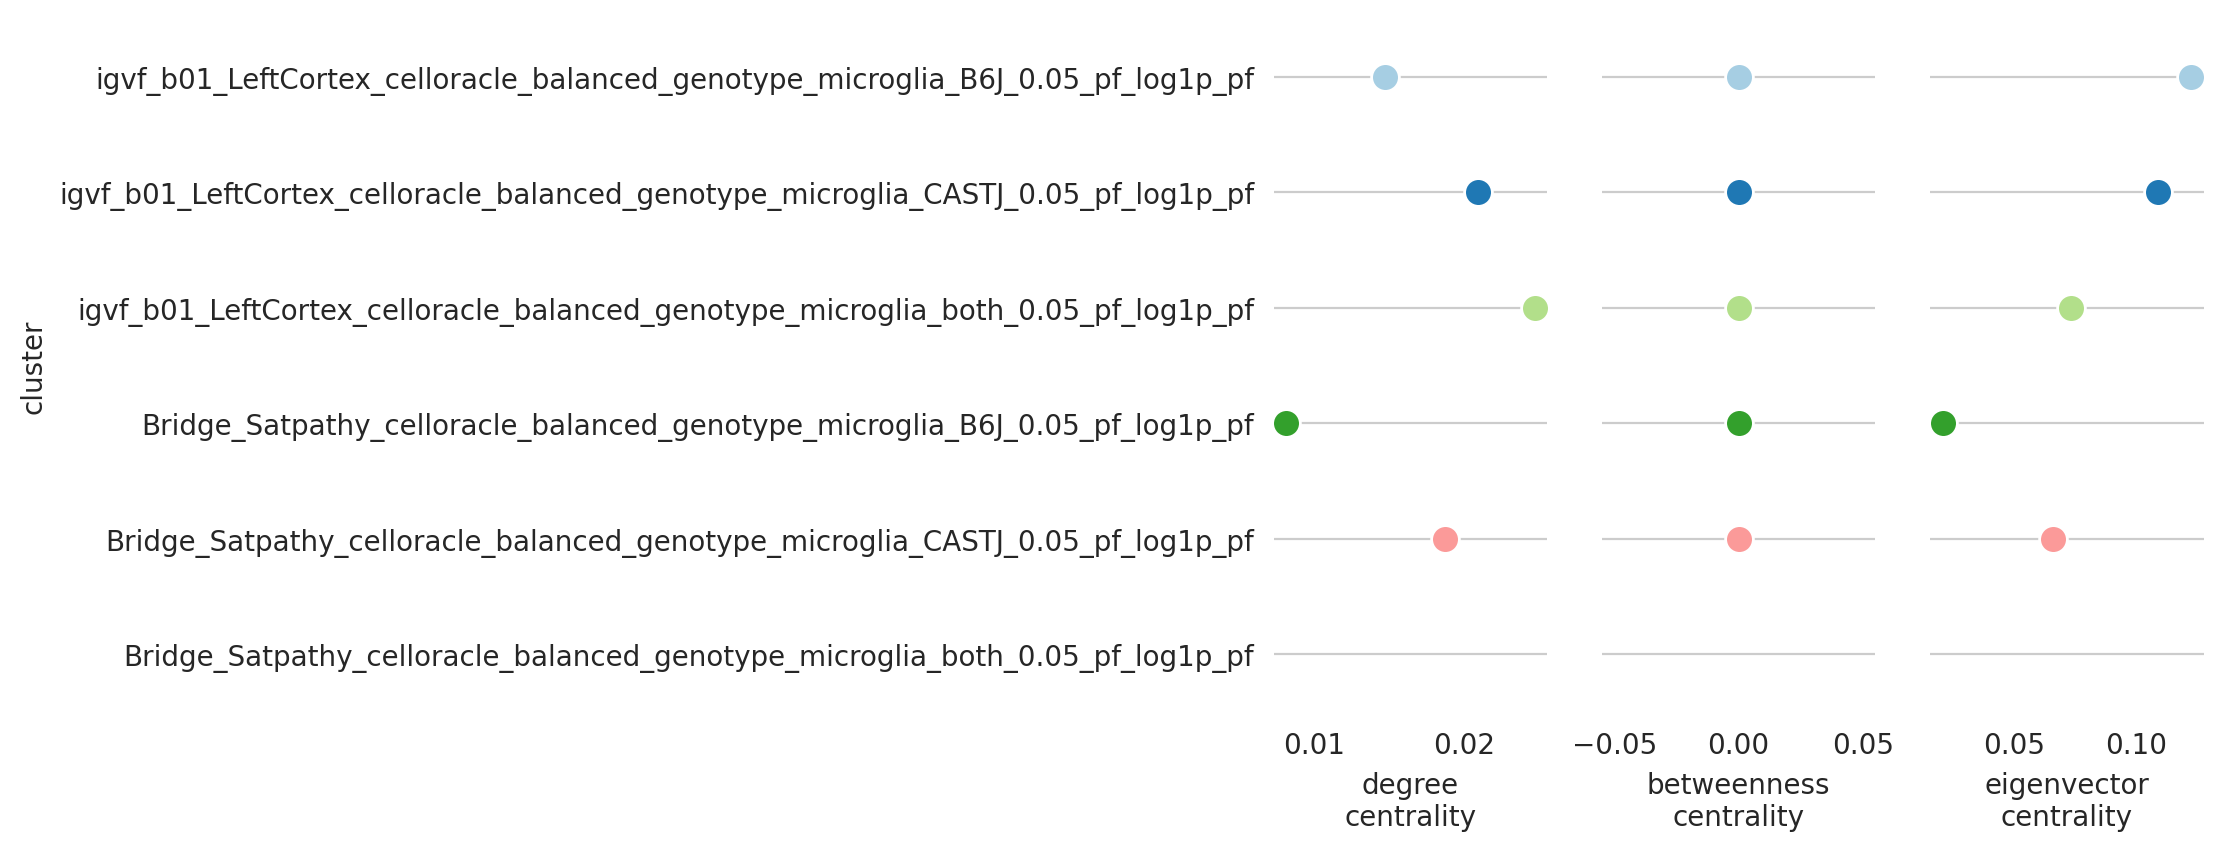

Sall1


IndexError: single positional indexer is out-of-bounds

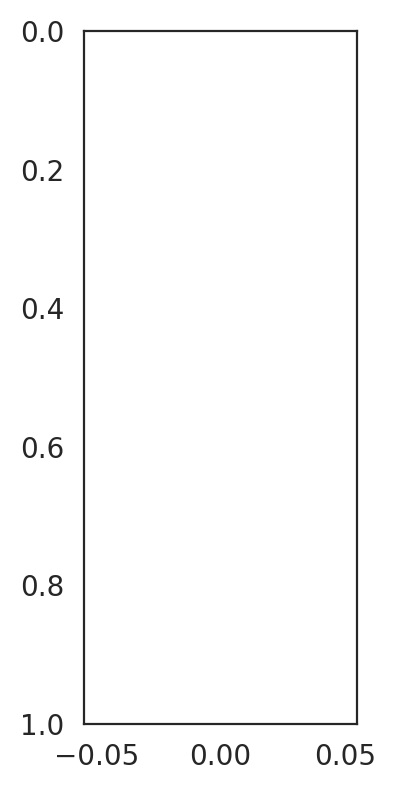

In [49]:
for tf in lit_tfs:
    # Certain genes
    links.plot_score_per_cluster(goi=tf)